In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install free-mujoco-py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 19 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/univ

In [5]:
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-goth

In [2]:
!pip install cherry-rl learn2learn &> /dev/null

In [146]:
import random
import math

from copy import deepcopy

import cherry as ch
import gym
import numpy as np
import torch
from cherry.algorithms import a2c, trpo
from cherry.models.robotics import LinearValue
from tqdm import tqdm

import learn2learn as l2l

import torch as th
import torch.nn as nn
from torch import autograd
from torch.distributions.kl import kl_divergence
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.distributions import Normal, Categorical


In [149]:
env = gym.make('AntForwardBackward-v1')

In [150]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [151]:
class Actor(nn.Module):
    def __init__(self, env, hidden_size=100):
        super().__init__()
        self.input_size = env.observation_space.shape[0]
        self.actor_output_size = env.action_space.shape[0]

        self.l1 = layer_init(nn.Linear(self.input_size, hidden_size))
        self.l2 = layer_init(nn.Linear(hidden_size, hidden_size))
        self.output = layer_init(nn.Linear(hidden_size, self.actor_output_size), std=0.01)
        self.activation = nn.ReLU()
        self.distribution = ch.distributions.ActionDistribution(env)

    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.output(x)
        mass = self.distribution(x)

        return mass

In [152]:
EPSILON = 1e-6

def linear_init(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        module.bias.data.zero_()
    return module


class DiagNormalPolicy(nn.Module):

    def __init__(self, input_size, output_size, hiddens=None, activation='relu', device='cpu'):
        super(DiagNormalPolicy, self).__init__()
        self.device = device
        if hiddens is None:
            hiddens = [100, 100]
        if activation == 'relu':
            activation = nn.ReLU
        elif activation == 'tanh':
            activation = nn.Tanh
        layers = [linear_init(nn.Linear(input_size, hiddens[0])), activation()]
        for i, o in zip(hiddens[:-1], hiddens[1:]):
            layers.append(linear_init(nn.Linear(i, o)))
            layers.append(activation())
        layers.append(linear_init(nn.Linear(hiddens[-1], output_size)))
        self.mean = nn.Sequential(*layers)
        self.sigma = nn.Parameter(torch.Tensor(output_size))
        self.sigma.data.fill_(math.log(1))

    def density(self, state):
        state = state.to(self.device, non_blocking=True)
        loc = self.mean(state)
        scale = torch.exp(torch.clamp(self.sigma, min=math.log(EPSILON)))
        return Normal(loc=loc, scale=scale)

    def log_prob(self, state, action):
        density = self.density(state)
        return density.log_prob(action).mean(dim=1, keepdim=True)

    def forward(self, state):
        density = self.density(state)
        action = density.sample()
        return action


## Test

In [141]:
env = gym.make('HalfCheetahForwardBackward-v1')
env = ch.envs.ActionSpaceScaler(env)
task = [{'direction': -1.0}]
env.set_task(task[0])
env = ch.envs.Torch(env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [142]:
policy = DiagNormalPolicy(env.state_size, env.action_size, device="cuda")
policy.load_state_dict(torch.load("policy2.pt"))
policy = policy.to("cuda")

In [143]:
frames = []
rewards = []

state = env.reset()
while True:
    with torch.no_grad():
        mass = policy.density(state)
    action = mass.sample()
    state, rew, done, info = env.step(action)
    rewards.append(rew)
    frame = env.render(mode='rgb_array')
    frames.append(frame[::-1, ::].copy())

    if done:
        break

print(sum(rewards))

219.292132515162


In [144]:
import matplotlib.pyplot as plt
from matplotlib import animation

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=20)

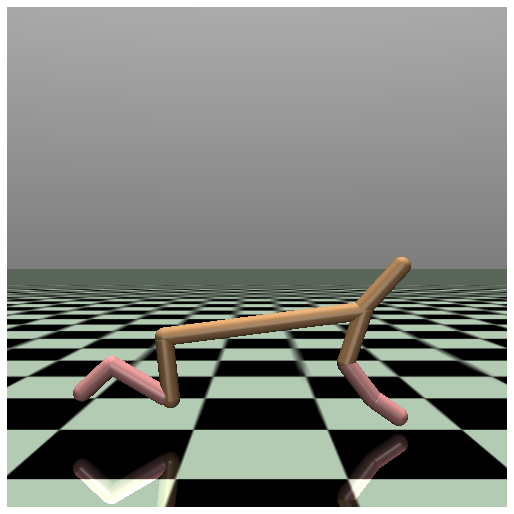

In [145]:
save_frames_as_gif(frames)

## Adapt

In [78]:
import math
from collections import deque 

import numpy as np
import gym
from gym import spaces

import torch as th
from torch import autograd, nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.distributions import kl_divergence
from torch.distributions import Normal, Categorical

import cherry as ch
from cherry.algorithms import trpo
from cherry.models.robotics import LinearValue


from tqdm import tqdm
from copy import deepcopy

In [79]:
import cherry.algorithms.a2c as a2c
import cherry.algorithms.trpo as trpo

In [136]:
TOTAL_STEPS = 20048
TRPO_STEPS = 2048
BATCH_SIZE = 128
NUM_BATCHES = TRPO_STEPS // BATCH_SIZE
NUM_LOOPS = (TOTAL_STEPS-1) // TRPO_STEPS + 1

GAMMA = 0.99
TAU = 0.95
MAX_KL = 0.01

CG_DAMPING = 0.1
CG_MAX_STEPS = 15

LS_MAX_ITER = 10
LS_SHRINK_FACTOR = 0.8

n_critic_updates = 10

ENT_WEIGHT = 0.0   # entropy bonus is not used by TRPO
VF_WEIGHT = 0.0  # value function is optimized separately
max_grad_norm = 0.0

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [137]:
def update(policy, baseline, replay, env):
    # Logging
    policy_objectives = []
    value_losses = []
    kl_divergences = []

    returns = ch.td.discount(GAMMA, replay.reward(), replay.done())
    baseline.fit(replay.state(), returns)

    with th.no_grad():
        next_state_value = baseline(replay[-1].next_state)
        values = baseline(replay.state())

    advantages = ch.generalized_advantage(GAMMA,
                                          TAU,
                                          replay.reward(),
                                          replay.done(),
                                          values,
                                          next_state_value)
    advantages = ch.normalize(advantages, epsilon=1e-8)

    actions = replay.action()
    if isinstance(env.action_space, spaces.Discrete):
        actions = actions.flatten()

    with th.no_grad():
        old_density = deepcopy(policy.density(replay.state()))
    density = policy.density(replay.state())

    # KL divergence
    kl_div = kl_divergence(density, old_density).mean()

    # Surrogate Loss
    log_prob = density.log_prob(actions).mean(dim=1, keepdim=True)
    surr_loss = -trpo.policy_loss(log_prob, replay.log_prob(), advantages)

    # Policy objective gradients
    grad = autograd.grad(surr_loss,
                         policy.parameters(),
                         retain_graph=True)
    grad = parameters_to_vector(grad).detach()

    # Hessian-vector
    Fvp = trpo.hessian_vector_product(kl_div, policy.parameters(), CG_DAMPING)

    # Computing search direction
    step = trpo.conjugate_gradient(Fvp, grad, CG_MAX_STEPS)
    lagrange_mult = 2 * MAX_KL / th.dot(step, Fvp(step))
    lagrange_mult = th.sqrt(lagrange_mult)
    step = step * lagrange_mult

    step_ = [th.zeros_like(p.data) for p in policy.parameters()]
    vector_to_parameters(step, step_)
    step = step_

    stepsize = 1.0
    search_success = False
    clone = deepcopy(policy)

    with th.no_grad():
        for ls_step in range(LS_MAX_ITER):

            for p, c, u in zip(policy.parameters(), clone.parameters(), step):
                p.data = c.data + stepsize * u.data

            # Recomputing KL
            new_density = policy.density(replay.state())
            new_kl = kl_divergence(old_density, new_density).mean()
            # Recomputing the policy log-probabilities
            new_log_probs = new_density.log_prob(actions).mean(dim=1, keepdim=True)

            # New policy objective
            new_surr_loss = -trpo.policy_loss(new_log_probs, replay.log_prob(), advantages)
            if new_kl < MAX_KL and surr_loss < new_surr_loss:
                search_success = True
                break

            stepsize *= LS_SHRINK_FACTOR

    if not search_success:
        # Revert to the original parameters
        for p, c in zip(policy.parameters(), clone.parameters()):
            p.data[:] = c.data[:]
        policy_objectives.append(surr_loss.item())
        kl_divergences.append(0)
    else:
        policy_objectives.append(new_surr_loss.item())
        kl_divergences.append(new_kl.item())

    # Log metrics
    env.log('was search successful', search_success)
    env.log('search depth', ls_step)
    env.log('kl divergence loss', np.mean(kl_divergences))
    env.log('policy objective', np.mean(policy_objectives))
    env.log('value loss', np.mean(value_losses))

In [138]:
def run(load=False):
    env = gym.make('HalfCheetahForwardBackward-v1')
    task = [{'direction': -1.0}]
    env.set_task(task[0])
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = ch.envs.Logger(env, interval=TRPO_STEPS)
    env = ch.envs.Torch(env)

    policy = DiagNormalPolicy(env.state_size, env.action_size, device=device).to(device)
    baseline = LinearValue(env.state_size, env.action_size).to(device)

    if load:
        baseline.load_state_dict(torch.load("baseline.pt"))
        policy.load_state_dict(torch.load("policy.pt"))

    replay = ch.ExperienceReplay(device=device)
    state = env.reset()
    ep_info_buffer = deque(maxlen=100)

    for i in range(NUM_LOOPS):
        
        steps = 0

        while steps < TRPO_STEPS:
            steps += 1

            with th.no_grad():
                mass = policy.density(state)
            action = mass.sample()
            log_prob = mass.log_prob(action).mean(dim=1, keepdim=True)

            next_state, reward, done, info = env.step(action)
            
            replay.append(state, action, reward, 
                        next_state, done,
                        log_prob=log_prob)
                        # value=value
                        # entropy=entropy           

            if done:
                ep_info_buffer.append(info['episode'])
                state = env.reset()
            else:
                state = next_state

        update(policy, baseline, replay, env)
        replay.empty()

        rr = [ep['r'] for ep in ep_info_buffer]
        print(np.mean(rr))

    torch.save(baseline.state_dict(), "baseline2.pt")
    torch.save(policy.state_dict(),"policy2.pt")


In [ ]:
run(load=True)